<a href="https://colab.research.google.com/github/AlexPiche/jax_rl/blob/master/SAC_implementation_in_Jax.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
%tensorflow_version 2.x

# Grab newest JAX version.
!pip install --upgrade -q jax==0.1.59 jaxlib==0.1.39

# use tfp for the action distribution
!pip install --upgrade tensorflow
!pip install --upgrade tensorflow-probability

use_tpu = False # somehow slower for this problem.

TensorFlow 2.x selected.
Requirement already up-to-date: tensorflow in /tensorflow-2.1.0/python3.6 (2.1.0)
Requirement already up-to-date: tensorflow-probability in /tensorflow-2.1.0/python3.6 (0.9.0)


In [0]:
if use_tpu:
  # Make sure the Colab Runtime is set to Accelerator: TPU.
  import requests
  import os
  if 'TPU_DRIVER_MODE' not in globals():
    url = 'http://' + os.environ['COLAB_TPU_ADDR'].split(':')[0] + ':8475/requestversion/tpu_driver_nightly'
    resp = requests.post(url)
    TPU_DRIVER_MODE = 1

  # The following is required to use TPU Driver as JAX's backend.
  from jax.config import config
  config.FLAGS.jax_xla_backend = "tpu_driver"
  config.FLAGS.jax_backend_target = "grpc://" + os.environ['COLAB_TPU_ADDR']
  print(config.FLAGS.jax_backend_target)  

In [0]:
import collections
import gym
import jax
import jax.numpy as jnp
import jax.random as jrandom
from jax.experimental import stax
from jax.experimental import optix
from jax.tree_util import tree_multimap
import numpy as np
import random
import functools
import time
import jax.scipy.stats.norm as norm
import matplotlib.pyplot as plt
from IPython.display import clear_output
import tensorflow as tf
from tensorflow_probability.python.distributions import _jax as distributions

In [0]:
AgentState = collections.namedtuple('agent_state', ['actor_params',
                                                    'actor_opt_state',
                                                    'q_params',
                                                    'q_opt_state',
                                                    'value_params',
                                                    'value_opt_state',
                                                    'target_value_params'])


In [0]:
class Agent:
  def __init__(self):
    super().__init__()
    self.alpha = 0.05
    self.tau = 0.005

  def init_params(self, rng, state_dims, action_dims):
    self.action_dims = action_dims[0]
    new_rng, rng_actor, rng_q1, rng_q2, rng_v = jrandom.split(rng, 5)

    init_random_params, self.actor_fun = stax.serial(stax.Dense(256), stax.Relu,
                                                     stax.Dense(256), stax.Relu,
                                                     stax.Dense(action_dims[0]*2))

    _, actor_params = init_random_params(rng_actor, state_dims)
    self.optimizer = optix.adam(learning_rate=3e-4)
    actor_opt_state = self.optimizer.init(actor_params)

    init_random_params, self.value_fun = stax.serial(stax.Dense(256), stax.Relu,
                                                     stax.Dense(256), stax.Relu,
                                                     stax.Dense(1))

    _, value_params = init_random_params(rng_v, state_dims)
    value_opt_state = self.optimizer.init(value_params)

    init_random_params, self.q_fun = stax.serial(stax.Dense(256), stax.Relu,
                                                 stax.Dense(256), stax.Relu,
                                                 stax.Dense(1))

    state_action_dims = (state_dims[0] + action_dims[0],)
    _, q_params1 = init_random_params(rng_q1, state_action_dims)
    _, q_params2 = init_random_params(rng_q2, state_action_dims)
    q_params1 = tree_multimap(lambda p: p.reshape((1,) + p.shape), q_params1)
    q_params2 = tree_multimap(lambda p: p.reshape((1,) + p.shape), q_params2)
    q_params = tree_multimap(lambda p1, p2: jnp.concatenate((p1, p2)), q_params1, q_params2)
    q_opt_state = self.optimizer.init(q_params)

    return new_rng, AgentState(actor_params=actor_params,
                               actor_opt_state=actor_opt_state,
                               q_params=q_params,
                               q_opt_state=q_opt_state,
                               value_params=value_params,
                               value_opt_state=value_opt_state,
                               target_value_params=value_params)
  
  @functools.partial(jax.jit, static_argnums=(0,))
  def act(self, rng, actor_state, state):
    new_rng, rng_action = jrandom.split(rng)
    actor_out = self.actor_fun(actor_state.actor_params, state)
    loc, log_scale = actor_out[:self.action_dims], actor_out[self.action_dims:]
    normal = distributions.Normal(loc=loc, scale=jnp.exp(log_scale))
    action = jnp.tanh(normal.sample(seed=rng_action))
    return new_rng, action

  def actor_loss(self, rng, actor_params, q_params, 
                 state, action, reward, done, next_state):
    
    actor_out = self.actor_fun(actor_params, state)
    
    loc, log_scale = actor_out[:, :self.action_dims], actor_out[:, self.action_dims:]
    normal = distributions.Normal(loc=loc, scale=jnp.exp(log_scale))
    z = normal.sample(seed=rng)
    new_action = jnp.tanh(z)
    epsilon = 1e-6
    log_prob = (normal.log_prob(z) - 
                jnp.log(1 - new_action**2 + epsilon)).sum(-1, keepdims=True)

    expected_new_q_value = jax.vmap(self.q_fun, (0, None))(q_params, jnp.concatenate([state, new_action], 1))
    expected_new_q_value = jnp.amin(expected_new_q_value, 0)
    policy_loss = (self.alpha * log_prob - expected_new_q_value).mean()
    policy_loss += 1e-3*(loc**2 + log_scale**2).mean()
    stats = {'policy_loss': policy_loss,
             'action_min': jnp.min(new_action),
             'action_mean': jnp.mean(new_action),
             'action_max': jnp.max(new_action),
             'scale_mean': jnp.mean(jnp.exp(log_scale)),
             'log_prob_mean': jnp.mean(log_prob)}
    return policy_loss, stats

  def value_loss(self, rng, v_params, actor_params, q_params,
                 state, action, reward, done, next_state):
    actor_out = self.actor_fun(actor_params, state)
    loc, log_scale = actor_out[:, :self.action_dims], actor_out[:, self.action_dims:]
    normal = distributions.Normal(loc=loc, scale=jnp.exp(log_scale))
    z = normal.sample(seed=rng)
    new_action = jnp.tanh(z)
    epsilon = 1e-6
    log_prob = (normal.log_prob(z) - 
                jnp.log(1 - new_action**2 + epsilon)).sum(-1, keepdims=True)
    value_pred = self.value_fun(v_params, state)
    expected_new_q_value = jax.vmap(self.q_fun, (0, None))(q_params,
                                                           jnp.concatenate([state, new_action], 1))
    expected_new_q_value = jnp.amin(expected_new_q_value, 0)
    next_value = expected_new_q_value - self.alpha * log_prob
    v_loss = (value_pred - next_value) ** 2
    stats = {'value_loss': jnp.mean(v_loss),
             'value_pred_mean': jnp.mean(value_pred),
             'value_target_mean': jnp.mean(next_value)}
    return jnp.mean(v_loss), stats

  def q_loss(self, rng, q_params, target_v_params,
             state, action, reward, done, next_state):
    q_pred = jax.vmap(self.q_fun, (0, None))(q_params,
                                             jnp.concatenate([state, action], 1))
    reward = jnp.expand_dims(reward, -1)
    done = jnp.expand_dims(done, -1)
    q_target = reward + 0.9 * (1 - done) * self.value_fun(target_v_params, next_state)
    q_target = jnp.expand_dims(q_target, 0)
    q_loss = 0.5 * (q_pred - q_target) ** 2 
    stats = {'q_loss': jnp.mean(q_loss),
             'q_pred_mean': jnp.mean(q_pred),
             'q_target_mean': jnp.mean(q_target)}
    return jnp.mean(q_loss), stats
  
  @functools.partial(jax.jit, static_argnums=(0,))
  def update(self, rng, agent_state, update_step, batch):
    new_rng, rng_actor, rng_q, rng_v = jrandom.split(rng, 4)
    g_a, stats_a = jax.grad(self.actor_loss, 1, has_aux=True)(rng_actor, 
                                                              agent_state.actor_params,
                                                              agent_state.q_params,
                                                              **batch)
    
    actor_update, new_actor_opt_state = self.optimizer.update(g_a,
                                                              agent_state.actor_opt_state)
    new_actor_params = tree_multimap(lambda p, u: p + u,
                                     agent_state.actor_params,
                                     actor_update)

    g_q, stats_q = jax.grad(self.q_loss, 1, has_aux=True)(rng_q, 
                                                          agent_state.q_params, 
                                                          agent_state.target_value_params,
                                                          **batch)
    
    q_update, new_q_opt_state = self.optimizer.update(g_q,
                                                      agent_state.q_opt_state)
    new_q_params = tree_multimap(lambda p, u: p + u,
                                 agent_state.q_params,
                                 q_update)

    g_v, stats_v = jax.grad(self.value_loss, 1, has_aux=True)(rng_v, 
                                                              agent_state.value_params, 
                                                              agent_state.actor_params, 
                                                              agent_state.q_params,
                                                              **batch)
    v_update, new_value_opt_state = self.optimizer.update(g_v,
                                                          agent_state.value_opt_state)
    new_value_params = tree_multimap(lambda p, u: p + u,
                                     agent_state.value_params,
                                     v_update)
    
    new_target_value_params = tree_multimap(lambda v, tv: self.tau*v + (1-self.tau)*tv,
                                            new_value_params,
                                            agent_state.target_value_params)
    
    new_agent_state = AgentState(actor_params=new_actor_params,
                                 actor_opt_state=new_actor_opt_state,
                                 q_params=new_q_params,
                                 q_opt_state=new_q_opt_state,
                                 value_params=new_value_params,
                                 value_opt_state=new_value_opt_state,
                                 target_value_params=new_target_value_params)
    
    stats = {**stats_a, **stats_q, **stats_v}

    return new_rng, new_agent_state, stats


In [0]:

# from https://github.com/higgsfield/RL-Adventure-2/blob/master/7.soft%20actor-critic.ipynb
class ReplayBuffer:
    def __init__(self, capacity):
        self.capacity = capacity
        self.buffer = []
        self.position = 0
    
    def push(self, state, action, reward, next_state, done):
        if len(self.buffer) < self.capacity:
            self.buffer.append(None)
        self.buffer[self.position] = (state, action, reward, next_state, done)
        self.position = (self.position + 1) % self.capacity
    
    def sample(self, batch_size):
        batch = random.sample(self.buffer, batch_size)
        state, action, reward, next_state, done = map(np.stack, zip(*batch))
        return {'state': state, 
                'action': action, 
                'reward': reward, 
                'next_state': next_state,
                'done': done}
    
    def __len__(self):
        return len(self.buffer)

In [0]:
class NormalizedActions(gym.ActionWrapper):
    def action(self, action):
        low  = self.action_space.low
        high = self.action_space.high
        
        action = low + (action + 1.0) * 0.5 * (high - low)
        action = np.clip(action, low, high)
        
        return action

    def reverse_action(self, action):
        low  = self.action_space.low
        high = self.action_space.high
        
        action = 2 * (action - low) / (high - low) - 1
        action = np.clip(action, low, high)
        
        return actions

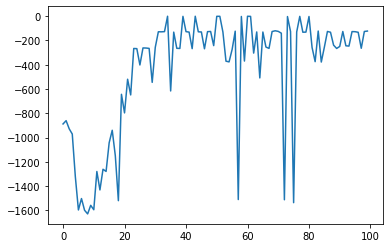

average episode time
4.08511745929718
action_max
0.9969379
action_mean
0.19508852
action_min
-0.9936564
log_prob_mean
0.67473245
policy_loss
21.490377
q_loss
0.09824231
q_pred_mean
-21.582933
q_target_mean
-21.713726
scale_mean
0.45254967
value_loss
0.43207008
value_pred_mean
-21.548885
value_target_mean
-21.48227


In [8]:
rng = jax.random.PRNGKey(0)
env = NormalizedActions(gym.make('Pendulum-v0'))
action_space = env.action_space.shape
observation_space = env.observation_space.shape
agent = Agent()
buffer = ReplayBuffer(int(1e6))

rng, agent_state = agent.init_params(rng, observation_space, action_space)

actor_update = 0
cumulative_rewards = []
stats = None
start_time = time.time()
for i in range(100):

  state = env.reset()
  done = False
  cumulative_reward = 0

  while not done:
    rng, action = agent.act(rng, agent_state, state)
    next_state, reward, done, _ = env.step(action)
    cumulative_reward += reward
    buffer.push(state, action, reward, next_state, done)
    state = next_state

    if buffer.__len__() > 1e3:
      batch = buffer.sample(128)
      rng, agent_state, stats = agent.update(rng, 
                                             agent_state,
                                             actor_update,
                                             batch)
      actor_update += 1

  cumulative_rewards.append(cumulative_reward)

  if stats and len(cumulative_rewards) % 10 == 0:
    clear_output()
    end_time = time.time()

    plt.plot(cumulative_rewards)
    plt.show()

    print('average episode time')
    print((end_time-start_time) / 10)

    for n, m in stats.items():
      print(n)
      print(m)
      
    start_time = time.time()
